# 第十一届 “中国软件杯”百度遥感赛项：变化检测功能

## 比赛介绍
---

“中国软件杯”大学生软件设计大赛是一项面向中国在校学生的公益性赛事，是2021年全国普通高校大学生竞赛榜单内竞赛。大赛由国家工业和信息化部、教育部、江苏省人民政府共同主办，致力于正确引导我国在校学生积极参加软件科研活动，切实增强自我创新能力和实际动手能力，为我国软件和信息技术服务业培养出更多高端、优秀的人才。2022年，百度飞桨承办了A组和B组两个赛道，本赛题为A组。

[比赛官网链接](https://aistudio.baidu.com/aistudio/competition/detail/151/0/introduction)

### 赛题背景

掌握国土资源利用和土地覆盖类型，是地理国情普查与监测的重要内容。高效获取准确、客观的土地利用情况，监测国土变化情况，可以为国家和地方提供地理国情信息决策支撑。随着遥感、传感器技术的发展，特别是多时相高分辨率遥感图像数据的普及，使我们可以足不出户，就能掌握全球任一地表的细微变化。

目前，我国遥感领域已步入了高分辨率影像的快车道，对遥感数据的分析应用服务的需求也与日俱增。传统方式对高分辨率卫星遥感图像的对特征刻画能力差且依赖人工经验工作量巨大。随着人工智能技术的兴起，特别是基于深度学习的图像识别方法获得了极大的发展，相关技术也推动了遥感领域的变革。相对于传统基于人海战术的目视解译方法，基于深度学习的遥感图像识别技术可以自动分析图像中的地物类型，在准确率和效率方面展现出极大的潜力。

此次赛题由百度飞桨和[北航LEVIR团队](http://levir.buaa.edu.cn/) 共同设置，要求选手使用百度AI Studio平台进行训练，基于国产化人工智能框架——百度飞桨PaddlePaddle框架进行开发，设计并开发一个可以通过深度学习技术实现对遥感图像自动解译的WEB系统。

### 任务说明

变化检测部分要求参赛者利用提供的训练数据，实现对多时相图像中的建筑变化检测。具体而言，多时相遥感图像建筑物变化检测任务是给定两张不同时间拍摄的相同位置（地理配准）的遥感图像，要求定位出其中建筑变化的区域。

参考链接：[什么是遥感影像变化检测？](https://baike.baidu.com/item/%E5%8F%98%E5%8C%96%E6%A3%80%E6%B5%8B/8636264)

### 数据集介绍

参见[数据集链接](https://aistudio.baidu.com/aistudio/datasetdetail/134796)和[赛题说明](https://aistudio.baidu.com/aistudio/competition/detail/151/0/task-definition)。

## 数据预处理
---

In [1]:
# 解压数据集
# 该操作涉及大量文件IO，可能需要一些时间
!unzip -o -d /home/aistudio/data/data134796/dataset /home/aistudio/data/data134796/train_data.zip > /dev/null
!unzip -o -d /home/aistudio/data/data134796/dataset /home/aistudio/data/data134796/test_data.zip > /dev/null

In [2]:
# 划分训练集/验证集，并生成文件名列表

import random
import os.path as osp
from glob import glob


# 随机数生成器种子
RNG_SEED = 666666
# 调节此参数控制训练集数据的占比
TRAIN_RATIO = 0.9
# 数据集路径
DATA_DIR = '/home/aistudio/data/data134796/dataset/'


def write_rel_paths(phase, names, out_dir, prefix=''):
    """将文件相对路径存储在txt格式文件中"""
    with open(osp.join(out_dir, phase+'.txt'), 'w') as f:
        for name in names:
            f.write(
                ' '.join([
                    osp.join(prefix, 'A', name),
                    osp.join(prefix, 'B', name),
                    osp.join(prefix, 'label', name)
                ])
            )
            f.write('\n')


random.seed(RNG_SEED)

# 随机划分训练集/验证集
names = list(map(osp.basename, glob(osp.join(DATA_DIR, 'train', 'label', '*.png'))))
# 对文件名进行排序，以确保多次运行结果一致
names.sort()
random.shuffle(names)
len_train = int(len(names)*TRAIN_RATIO) # 向下取整
write_rel_paths('train', names[:len_train], DATA_DIR, prefix='train')
write_rel_paths('val', names[len_train:], DATA_DIR, prefix='train')

# 处理测试集
test_names = map(osp.basename, glob(osp.join(DATA_DIR, 'test', 'A', '*.png')))
test_names = sorted(test_names)
write_rel_paths(
    'test', 
    test_names, 
    DATA_DIR,
    prefix='test'
)

print("数据集划分已完成。")


数据集划分已完成。


## 模型训练与推理
---

本项目使用[PaddleRS](https://github.com/PaddleCV-SIG/PaddleRS)套件搭建模型训练与推理框架。PaddleRS是基于飞桨开发的遥感处理平台，支持遥感图像分类、目标检测、图像分割、以及变化检测等常用遥感任务，能够帮助开发者更便捷地完成从训练到部署全流程遥感深度学习应用。在变化检测方面，PaddleRS目前支持9个state-of-the-art（SOTA）模型，且复杂的训练和推理过程被封装到数个API中，能够提供开箱即用的用户体验。

In [3]:
# 安装第三方库
!pip install scikit-image > /dev/null
!pip install matplotlib==3.4 > /dev/null

# 安装PaddleRS（AI Studio上缓存的版本）
!unzip -o -d /home/aistudio/ /home/aistudio/data/data135375/PaddleRS-develop.zip > /dev/null
!mv /home/aistudio/PaddleRS-develop /home/aistudio/PaddleRS
!pip install -e /home/aistudio/PaddleRS > /dev/null
# 因为`sys.path`可能没有及时更新，这里选择手动更新
import sys
sys.path.append('/home/aistudio/PaddleRS')

You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [4]:
# 导入一些需要用到的库

import random
import os
import os.path as osp
from copy import deepcopy
from functools import partial

import numpy as np
import paddle
import paddlers as pdrs
from paddlers import transforms as T
from skimage.io import imread, imsave
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


[05-28 09:55:47 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported


In [5]:
# 定义全局变量
# 可在此处调整实验所用超参数

# 随机种子
SEED = 888888

# 数据集路径
DATA_DIR = '/home/aistudio/data/data134796/dataset/'
# 实验路径。实验目录下保存输出的模型权重和结果
EXP_DIR = '/home/aistudio/exp/'
# 保存最佳模型的路径
BEST_CKP_PATH = osp.join(EXP_DIR, 'best_model', 'model.pdparams')

# 训练的epoch数
NUM_EPOCHS = 150
# 每多少个epoch保存一次模型权重参数
SAVE_INTERVAL_EPOCHS = 5
# 初始学习率
LR = 0.0005
# 学习率衰减步长（注意，单位为迭代次数而非epoch数），即每多少次迭代将学习率衰减一半
DECAY_STEP = 1000
# 训练阶段 batch size
TRAIN_BATCH_SIZE = 16
# 推理阶段 batch size
INFER_BATCH_SIZE = 16
# 加载数据所使用的进程数
NUM_WORKERS = 4
# 裁块大小
CROP_SIZE = 512
# 模型推理阶段使用的滑窗步长
STRIDE = 64
# 影像原始大小
ORIGINAL_SIZE = (1024, 1024)

In [6]:
# 固定随机种子，尽可能使实验结果可复现

random.seed(SEED)
np.random.seed(SEED)
paddle.seed(SEED)

In [7]:
# 定义一些辅助函数

def info(msg, **kwargs):
    print(msg, **kwargs)


def warn(msg, **kwargs):
    print('\033[0;31m'+msg, **kwargs)


def quantize(arr):
    return (arr*255).astype('uint8')

### 模型构建

作为演示，本项目选用LEVIR小组2021年的作品——基于Transformer的变化检测模型BIT-CD[1]。原论文请参考[此链接](https://ieeexplore.ieee.org/document/9491802)，原作者官方实现请参考[此链接](https://github.com/justchenhao/BIT_CD)。

> [1] Hao Chen, Zipeng Qi, and Zhenwei Shi. **Remote Sensing Image Change Detection with Transformers.** *IEEE Transactions on Geoscience and Remote Sensing.*

In [8]:
# 调用PaddleRS API一键构建模型
model = pdrs.tasks.BIT(
    # 模型输出类别数
    num_classes=2,
    # 是否使用混合损失函数，默认使用交叉熵损失函数训练
    use_mixed_loss=False,
    # 模型输入通道数
    in_channels=3,
    # 模型使用的骨干网络，支持'resnet18'或'resnet34'
    backbone='resnet34',
    # 骨干网络中的resnet stage数量
    n_stages=4,
    # 是否使用tokenizer获取语义token
    use_tokenizer=True,
    # token的长度
    token_len=4,
    # 若不使用tokenizer，则使用池化方式获取token。此参数设置池化模式，有'max'和'avg'两种选项，分别对应最大池化与平均池化
    pool_mode='max',
    # 池化操作输出特征图的宽和高（池化方式得到的token的长度为pool_size的平方）
    pool_size=2,
    # 是否在Transformer编码器中加入位置编码（positional embedding）
    enc_with_pos=True,
    # Transformer编码器使用的注意力模块（attention block）个数
    enc_depth=1,
    # Transformer编码器中每个注意力头的嵌入维度（embedding dimension）
    enc_head_dim=64,
    # Transformer解码器使用的注意力模块个数
    dec_depth=16,
    # Transformer解码器中每个注意力头的嵌入维度
    dec_head_dim=16
)

W0528 09:55:48.580174   163 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0528 09:55:48.584370   163 device_context.cc:465] device: 0, cuDNN Version: 7.6.
100%|██████████| 128669/128669 [00:01<00:00, 65298.54it/s]


In [9]:
# 查看组网信息
# 在PaddleRS中，可通过ChangeDetector对象的net属性获取paddle.nn.Layer类型组网
model.net

BIT(
  (backbone): Backbone(
    (resnet): ResNet(
      (conv1): Conv2D(3, 64, kernel_size=[7, 7], stride=[2, 2], padding=3, data_format=NCHW)
      (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      (relu): ReLU()
      (maxpool): MaxPool2D(kernel_size=3, stride=2, padding=1)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
          (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
          (relu): ReLU()
          (conv2): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
          (bn2): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
          (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
          (relu): ReLU()
          (conv2): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
      

### 数据集构建

In [10]:
# 构建需要使用的数据变换（数据增强、预处理）
# 使用Compose组合多种变换方式。Compose中包含的变换将按顺序串行执行
train_transforms = T.Compose([
    # 随机裁剪
    T.RandomCrop(
        # 裁剪区域将被缩放到此大小
        crop_size=CROP_SIZE,
        # 将裁剪区域的横纵比固定为1
        aspect_ratio=[1.0, 1.0],
        # 裁剪区域相对原始影像长宽比例在一定范围内变动，最小不低于原始长宽的1/5
        scaling=[0.2, 1.0]
    ),
    #对输入进行随机色彩变换
    T.RandomDistort(),
    #对输入进行随机模糊
    T.RandomBlur(),
    #随机交换两个输入图像
    T.RandomSwap(),
    # 以50%的概率实施随机水平翻转
    T.RandomHorizontalFlip(prob=0.5),
    # 以50%的概率实施随机垂直翻转
    T.RandomVerticalFlip(prob=0.5),
    # 数据归一化到[-1,1]
    T.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
eval_transforms = T.Compose([
    # 在验证阶段，输入原始尺寸影像，对输入影像仅进行归一化处理
    # 验证阶段与训练阶段的数据归一化方式必须相同
    T.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# 实例化数据集
train_dataset = pdrs.datasets.CDDataset(
    data_dir=DATA_DIR,
    file_list=osp.join(DATA_DIR, 'train.txt'),
    label_list=None,
    transforms=train_transforms,
    num_workers=NUM_WORKERS,
    shuffle=True,
    binarize_labels=True
)
eval_dataset = pdrs.datasets.CDDataset(
    data_dir=DATA_DIR,
    file_list=osp.join(DATA_DIR, 'val.txt'),
    label_list=None,
    transforms=eval_transforms,
    num_workers=0,
    shuffle=False,
    binarize_labels=True
)

2022-05-28 09:55:53 [INFO]	573 samples in file /home/aistudio/data/data134796/dataset/train.txt
2022-05-28 09:55:53 [INFO]	64 samples in file /home/aistudio/data/data134796/dataset/val.txt


### 模型训练

使用AI Studio高级版硬件配置（16G V100）和默认的超参数，训练总时长约为50分钟，训练结束时验证集上最高的mIoU指标约为0.89（参考值，实际值可能存在波动）。

如果在训练中启用了VisualDL日志记录的功能（默认开启），则可以在“数据模型可视化”页签中查看可视化结果，请将logdir设置为`EXP_DIR`目录下的vdl_log子目录。在notebook中使用VisualDL的相关教程可参考[此处](https://ai.baidu.com/ai-doc/AISTUDIO/Dk3e2vxg9#visualdl%E5%B7%A5%E5%85%B7)。

需要注意的是，PaddleRS默认以mIoU评价验证集上的最优模型，而赛事官方则选用F1分数作为评价指标。

**变化检测任务的mIoU与F1分数指标定义：**

$$mIoU=\frac{1}{2}\left(\frac{TP}{FN+FP+TP}+\frac{TN}{FP+FN+TN}\right)$$
$$F1=\frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

式中，$TP$表示预测为变化且实际为变化的样本数，$TN$表示预测为不变且实际为不变的样本数，$FP$表示预测为变化但实际为不变的样本数，$FN$表示预测为不变但实际为变化的样本数。

此外，PaddleRS在验证集上汇报针对每一类的指标，因此对于二类变化检测来说，category_acc、category_F1-score等指标均存在两个数据项，以列表形式体现。由于变化检测任务主要关注变化类，因此观察和比较每种指标的第二个数据项（即列表的第二个元素）是更有意义的。

In [11]:
# 若实验目录不存在，则新建之（递归创建目录）
if not osp.exists(EXP_DIR):
    os.makedirs(EXP_DIR)

In [12]:
# 构建学习率调度器和优化器

# 制定定步长学习率衰减策略
lr_scheduler = paddle.optimizer.lr.StepDecay(
    LR,
    step_size=DECAY_STEP,
    # 学习率衰减系数，这里指定每次减半
    gamma=0.5
)
# 构造Adam优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.net.parameters()
)

In [13]:
# 调用PaddleRS API实现一键训练
model.train(
    num_epochs=NUM_EPOCHS,
    train_dataset=train_dataset,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_dataset=eval_dataset,
    optimizer=optimizer,
    save_interval_epochs=SAVE_INTERVAL_EPOCHS,
    # 每多少次迭代记录一次日志
    log_interval_steps=10,  
    save_dir=EXP_DIR,
    # 是否使用early stopping策略，当精度不再改善时提前终止训练
    early_stop=False,
    # 是否启用VisualDL日志功能
    use_vdl=True,
    # 指定从某个检查点继续训练
    resume_checkpoint=None
)

2022-05-28 09:56:09 [INFO]	[TRAIN] Epoch=1/150, Step=10/35, loss=0.310168, lr=0.000500, time_each_step=1.58s, eta=2:17:46
2022-05-28 09:56:22 [INFO]	[TRAIN] Epoch=1/150, Step=20/35, loss=0.215475, lr=0.000500, time_each_step=1.22s, eta=1:46:20
2022-05-28 09:56:34 [INFO]	[TRAIN] Epoch=1/150, Step=30/35, loss=0.101059, lr=0.000500, time_each_step=1.22s, eta=1:46:0
2022-05-28 09:56:40 [INFO]	[TRAIN] Epoch 1 finished, loss=0.2641413 .
2022-05-28 09:56:49 [INFO]	[TRAIN] Epoch=2/150, Step=5/35, loss=0.137947, lr=0.000500, time_each_step=1.49s, eta=2:9:3
2022-05-28 09:57:01 [INFO]	[TRAIN] Epoch=2/150, Step=15/35, loss=0.130755, lr=0.000500, time_each_step=1.22s, eta=1:45:24
2022-05-28 09:57:13 [INFO]	[TRAIN] Epoch=2/150, Step=25/35, loss=0.072628, lr=0.000500, time_each_step=1.22s, eta=1:45:17
2022-05-28 09:57:25 [INFO]	[TRAIN] Epoch=2/150, Step=35/35, loss=0.102020, lr=0.000500, time_each_step=1.22s, eta=1:45:4
2022-05-28 09:57:25 [INFO]	[TRAIN] Epoch 2 finished, loss=0.10576593 .
2022-05-28

In [ ]:
# 查看实验目录中存储的已训练好的模型
# `best_model`子目录对应验证集上指标最好的模型
# 其中，`eval_details.json`包含验证阶段记录的混淆矩阵信息；`model.pdopt`包含训练过程中使用到的优化器的状态参数；
# `model.pdparams`包含模型的权重参数；`model.yml`包含模型的配置文件（包括预处理参数、模型规格参数等）
!ls /home/aistudio/exp/best_model/

### 模型推理

使用AI Studio高级版硬件配置（16G V100）和默认的超参数，推理总时长约为4分钟。

推理脚本使用固定阈值法从变化概率图获取二值变化图（binary change map），默认阈值为0.5，可根据模型实际表现调整阈值。当然，也可以换用[Otsu法](https://baike.baidu.com/item/otsu/16252828?fr=aladdin)、[k-means聚类法](https://baike.baidu.com/item/K%E5%9D%87%E5%80%BC%E8%81%9A%E7%B1%BB%E7%AE%97%E6%B3%95/15779627)等更先进的阈值分割算法。
        
模型前向推理结果存储在`EXP_DIR`目录下的out子目录中，可将该子目录内的文件打包、并将压缩文件重命名后提交到比赛系统。在提交结果前，请仔细阅读[提交规范](https://aistudio.baidu.com/aistudio/competition/detail/151/0/submit-result)。

In [14]:
# 定义推理阶段使用的数据集

class InferDataset(paddle.io.Dataset):
    """
    变化检测推理数据集。

    Args:
        data_dir (str): 数据集所在的目录路径。
        transforms (paddlers.transforms.Compose): 需要执行的数据变换操作。
    """

    def __init__(
        self,
        data_dir,
        transforms
    ):
        super().__init__()

        self.data_dir = data_dir
        self.transforms = deepcopy(transforms)

        pdrs.transforms.arrange_transforms(
            model_type='changedetector',
            transforms=self.transforms,
            mode='test'
        )

        with open(osp.join(data_dir, 'test.txt'), 'r') as f:
            lines = f.read()
            lines = lines.strip().split('\n')

        samples = []
        names = []
        for line in lines:
            items = line.strip().split(' ')
            items = list(map(pdrs.utils.path_normalization, items))
            item_dict = {
                'image_t1': osp.join(data_dir, items[0]),
                'image_t2': osp.join(data_dir, items[1])
            }
            samples.append(item_dict)
            names.append(osp.basename(items[0]))

        self.samples = samples
        self.names = names

    def __getitem__(self, idx):
        name = self.names[idx]
        sample = deepcopy(self.samples[idx])
        output = self.transforms(sample)
        return name, \
               paddle.to_tensor(output[0]), \
               paddle.to_tensor(output[1]),

    def __len__(self):
        return len(self.samples)

In [15]:
# 考虑到原始影像尺寸较大，以下类和函数与影像裁块-拼接有关。

class WindowGenerator:
    def __init__(self, h, w, ch, cw, si=1, sj=1):
        self.h = h
        self.w = w
        self.ch = ch
        self.cw = cw
        if self.h < self.ch or self.w < self.cw:
            raise NotImplementedError
        self.si = si
        self.sj = sj
        self._i, self._j = 0, 0

    def __next__(self):
        # 列优先移动（C-order）
        if self._i > self.h:
            raise StopIteration
        
        bottom = min(self._i+self.ch, self.h)
        right = min(self._j+self.cw, self.w)
        top = max(0, bottom-self.ch)
        left = max(0, right-self.cw)

        if self._j >= self.w-self.cw:
            if self._i >= self.h-self.ch:
                # 设置一个非法值，使得迭代可以early stop
                self._i = self.h+1
            self._goto_next_row()
        else:
            self._j += self.sj
            if self._j > self.w:
                self._goto_next_row()

        return slice(top, bottom, 1), slice(left, right, 1)

    def __iter__(self):
        return self

    def _goto_next_row(self):
        self._i += self.si
        self._j = 0

    
def crop_patches(dataloader, ori_size, window_size, stride):
    """
    将`dataloader`中的数据裁块。

    Args:
        dataloader (paddle.io.DataLoader): 可迭代对象，能够产生原始样本（每个样本中包含任意数量影像）。
        ori_size (tuple): 原始影像的长和宽，表示为二元组形式(h,w)。
        window_size (int): 裁块大小。
        stride (int): 裁块使用的滑窗每次在水平或垂直方向上移动的像素数。

    Returns:
        一个生成器，能够产生iter(`dataloader`)中每一项的裁块结果。一幅图像产生的块在batch维度拼接。例如，当`ori_size`为1024，而
            `window_size`和`stride`均为512时，`crop_patches`返回的每一项的batch_size都将是iter(`dataloader`)中对应项的4倍。
    """

    for name, *ims in dataloader:
        ims = list(ims)
        h, w = ori_size
        win_gen = WindowGenerator(h, w, window_size, window_size, stride, stride)
        all_patches = []
        for rows, cols in win_gen:
            # NOTE: 此处不能使用生成器，否则因为lazy evaluation的缘故会导致结果不是预期的
            patches = [im[...,rows,cols] for im in ims]
            all_patches.append(patches)
        yield name[0], tuple(map(partial(paddle.concat, axis=0), zip(*all_patches)))


def recons_prob_map(patches, ori_size, window_size, stride):
    """从裁块结果重建原始尺寸影像，与`crop_patches`相对应"""
    # NOTE: 目前只能处理batch size为1的情况
    h, w = ori_size
    win_gen = WindowGenerator(h, w, window_size, window_size, stride, stride)
    prob_map = np.zeros((h,w), dtype=np.float)
    cnt = np.zeros((h,w), dtype=np.float)
    # XXX: 需要保证win_gen与patches具有相同长度。此处未做检查
    for (rows, cols), patch in zip(win_gen, patches):
        prob_map[rows, cols] += patch
        cnt[rows, cols] += 1
    prob_map /= cnt
    return prob_map

In [16]:
# 若输出目录不存在，则新建之（递归创建目录）
out_dir = osp.join(EXP_DIR, 'out')
if not osp.exists(out_dir):
    os.makedirs(out_dir)

# 为模型加载历史最佳权重
state_dict = paddle.load(BEST_CKP_PATH)
# 同样通过net属性访问组网对象
model.net.set_state_dict(state_dict)

# 实例化测试集
test_dataset = InferDataset(
    DATA_DIR,
    # 注意，测试阶段使用的归一化方式需与训练时相同
    T.Compose([
        T.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])
)

# 创建DataLoader
test_dataloader = paddle.io.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    return_list=True
)

In [17]:
# 推理过程主循环
info("模型推理开始")

model.net.eval()
len_test = len(test_dataset)
test_patches = crop_patches(
    test_dataloader,
    ORIGINAL_SIZE,
    CROP_SIZE,
    STRIDE
)
with paddle.no_grad():
    for name, (t1, t2) in tqdm(test_patches, total=len_test):
        shape = paddle.shape(t1)
        pred = paddle.zeros(shape=(shape[0],2,*shape[2:]))
        for i in range(0, shape[0], INFER_BATCH_SIZE):
            pred[i:i+INFER_BATCH_SIZE] = model.net(t1[i:i+INFER_BATCH_SIZE], t2[i:i+INFER_BATCH_SIZE])[0]
        # 取softmax结果的第1（从0开始计数）个通道的输出作为变化概率
        prob = paddle.nn.functional.softmax(pred, axis=1)[:,1]
        # 由patch重建完整概率图
        prob = recons_prob_map(prob.numpy(), ORIGINAL_SIZE, CROP_SIZE, STRIDE)
        # 默认将阈值设置为0.5，即，将变化概率大于0.5的像素点分为变化类
        out = quantize(prob>0.5)

        imsave(osp.join(out_dir, name), out, check_contrast=False)

info("模型推理完成")
        

模型推理开始


100%|██████████| 363/363 [09:11<00:00,  1.52s/it]


模型推理完成


In [18]:
!zip -q -r submssion5-28-1.zip /home/aistudio/exp/out

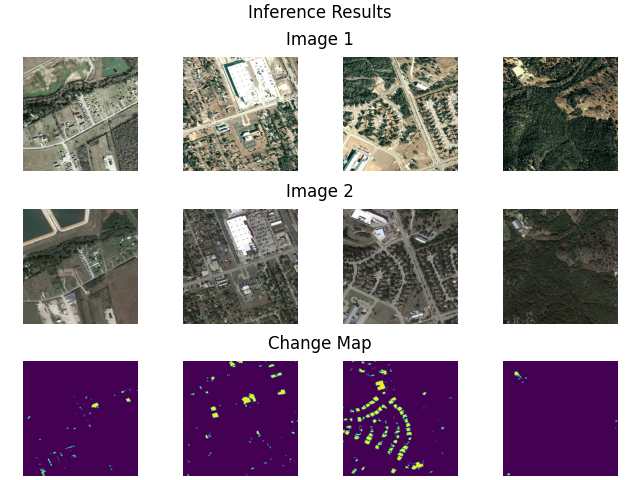

In [23]:
# 推理结果展示
# 重复运行本单元可以查看不同结果

def show_images_in_row(im_paths, fig, title=''):
    n = len(im_paths)
    fig.suptitle(title)
    axs = fig.subplots(nrows=1, ncols=n)
    for idx, (path, ax) in enumerate(zip(im_paths, axs)):
        # 去掉刻度线和边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

        im = imread(path)
        ax.imshow(im)


# 需要展示的样本个数
num_imgs_to_show = 4
# 随机抽取样本
chosen_indices = random.choices(range(len_test), k=num_imgs_to_show)

# 参考 https://stackoverflow.com/a/68209152
fig = plt.figure(constrained_layout=True)
fig.suptitle("Inference Results")

subfigs = fig.subfigures(nrows=3, ncols=1)

# 读入第一时相影像
im_paths = [osp.join(DATA_DIR, test_dataset.samples[idx]['image_t1']) for idx in chosen_indices]
show_images_in_row(im_paths, subfigs[0], title='Image 1')

# 读入第二时相影像
im_paths = [osp.join(DATA_DIR, test_dataset.samples[idx]['image_t2']) for idx in chosen_indices]
show_images_in_row(im_paths, subfigs[1], title='Image 2')

# 读入变化图
im_paths = [osp.join(out_dir, test_dataset.names[idx]) for idx in chosen_indices]
show_images_in_row(im_paths, subfigs[2], title='Change Map')

# 渲染结果
fig.canvas.draw()
Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

In [ ]:
# 将推理结果打包并压缩为zip文件。如果修改了默认输出目录，也需要在此指令中做出对应修改。
# 官方typo: submission -> submisson
!zip -j submisson.zip /home/aistudio/exp/out/* > /dev/null

## 参考资料
---

- [遥感数据介绍](https://github.com/PaddleCV-SIG/PaddleRS/blob/develop/docs/data/rs_data_cn.md)
- [PaddleRS文档](https://github.com/PaddleCV-SIG/PaddleRS/blob/develop/tutorials/train/README.md)